<a href="https://colab.research.google.com/github/hyun907/nlp-pretraining-ground/blob/main/01_1_news_classification_refactored.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 뉴스 본문 분류 리팩토링
**TF-IDF + 파이프라인 + 모델 비교(LinearSVC / LogisticRegression / ComplementNB)**  

## **주요 개선 사항**

**데이터 누수(Data Leakage) 방지**: 텍스트 전처리 및 벡터화를 학습 데이터(X_train)에 대해서만 fit하고, 테스트 데이터(X_test)에는 transform만 하는 구조를 Pipeline을 이용해 구현함으로써, 테스트 데이터의 정보가 학습에 영향을 주는 데이터 누수를 근본적으로 방지했습니다.

**코드의 효율성 및 가독성 향상**: 전처리(TfidfVectorizer)와 모델(clf)을 하나의 Pipeline으로 묶어 코드를 간결하게 만들고, 재사용성을 높였습니다.

**모델 다양화 및 비교**: 기존의 RandomForestClassifier 외에 LinearSVC, LogisticRegression, ComplementNB와 같은 다른 텍스트 분류에 적합한 모델들을 추가하여 성능을 비교 분석했습니다.

**평가 지표 확장**: 단순히 정확도(Accuracy)만 보던 것에서 나아가, F1-score, 혼동 행렬(Confusion Matrix), 오분류 사례 분석까지 포함하여 모델의 성능을 더 깊이 이해할 수 있게 되었습니다.

## **요약**
- 데이터 누수 방지 구조로 전면 리팩토링
- 전처리/벡터화/모델을 `Pipeline`으로 일원화
- 정확도 외 F1, 혼동행렬, 오분류 분석 포함
- 한국어 환경에서 효율적인 n-gram 기본 튜닝 제공

In [57]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB

# 재현성
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. 데이터 로드 및 기본 점검

In [ ]:
# 경로와 파일명은 프로젝트 구조에 맞게 수정
DATA_PATH = "data/bigkinds_data.xlsx"

df = pd.read_excel(DATA_PATH)
print(df.shape)
df.head(3)


(20000, 19)


,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,사건/사고 분류3,인물,위치,기관,키워드,특성추출(가중치순 상위 50개),본문,URL,분석제외 여부
0,8.100101e+06,20250725,KBS,박상용,"공동주택 11,000세대 ‘미착공’ 침체 장기화 우려",경제>부동산,NaN,NaN,NaN,NaN,NaN,NaN,"동해안,강릉,속초,경기,강원도,춘천,강원,만천리","동원,정부,건설교통국","미착공,공동,주택,세대,침체,장기화,앵커,강원,실적,아파트,착공,5년,침체,부동산,...","강원,건설사,공동주택,강원도,부동산,000세대,동해안,예정집,박상용,시군,미착공,촬...",[KBS 춘천]\n [앵커]\n\n 강원도 내 아파트 착공 실적이 최근 5년 새 가...,https://news.kbs.co.kr/news/view.do?ncd=831385...,NaN
1,8.100101e+06,20250725,KBS,정재훈,‘성착취 의혹’ 국민의힘 당직자 자진 사퇴,사회>여성,사회>교육_시험,정치>국회_정당,NaN,NaN,NaN,NaN,대전여성폭력방지상담소,"긴급,윤리위원회,대전시당,국민의힘","성착취,의혹,국민,사퇴,당직자,자진,배우자,성착취,의혹,국민,A씨,대전시,당직자,2...","당직자,대전시당,성착취,대전여성폭력방지상담소,상담소,위원회,사회단체,사실관계,피해자...",[KBS 대전]\n배우자를 성착취했다는 의혹을 받고 있는 국민의힘 대전시당 당직자 ...,https://news.kbs.co.kr/news/view.do?ncd=831390...,NaN
2,4.100078e+06,20250725,뉴스핌,류기찬,지하철 4호선 길음역 인근 흉기난동 사고 발생,문화>방송_연예,NaN,NaN,NaN,NaN,NaN,NaN,"4호선,서울 지하,길음역","인턴,과학수사대","지하철,발생,길음역,인근,흉기,난동,사고,류기찬,인턴,25일,4호,서울,지하철,길음...","서울,류기찬,길음역,수사대,과학수사대,4호,사고,지하철,발생,인근,흉기,진행,감식,...",[서울=뉴스핌] 류기찬 인턴기자 = 25일 밤 서울 지하철 4호선 길음역 인근에서 ...,https://www.newspim.com/news/view/20250725000983,NaN


## 2. 컬럼 선택, 샘플링, 결측/중복 제거

In [ ]:
# 필요한 컬럼만 사용
COL_TEXT = "본문"
COL_LABEL = "통합 분류1"

use_cols = [COL_TEXT, COL_LABEL]
df = df[use_cols].copy()

# 결측 제거
df = df.dropna(subset=use_cols)

# 중복 기사 제거(본문 기준)
df = df.drop_duplicates(subset=[COL_TEXT])

# (선택) 무작위 샘플링: 5,000건
if len(df) > 5000:
    df = df.sample(n=5000, random_state=RANDOM_STATE).reset_index(drop=True)

df.shape, df[COL_LABEL].value_counts().head()


((5000, 2),
 통합 분류1
 지역>충남       209
 경제>유통       203
 사회>사건_사고    202
 정치>국회_정당    198
 정치>청와대      168
 Name: count, dtype: int64)

## 3. 라벨 인코딩

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["label"] = le.fit_transform(df[COL_LABEL])
classes = le.classes_  # 역변환/표시용
print("클래스 개수:", len(classes))
pd.Series(df["label"]).value_counts(normalize=True).sort_index().head()

클래스 개수: 85


,proportion
label,
0,0.0056
1,0.0134
2,0.0140
3,0.0028
4,0.0062


## 라벨 인코딩을 하는 이유
### 1. 문제 상황

* 머신러닝 모델은 보통 **숫자**만 이해합니다.
* 하지만 우리가 가진 라벨(`통합 분류1`)은 **문자열**일 수 있습니다.

```
예: 정치, 경제, 사회, 문화, 스포츠 ...
```

문자열은 모델에 바로 넣을 수 없기 때문에 숫자로 바꿔줘야 합니다.


### 2. LabelEncoder의 역할

```python
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["label"] = le.fit_transform(df[COL_LABEL])
```

* `LabelEncoder()`는 문자열 → 정수 매핑을 자동으로 해주는 도구

예시:

```python
라벨 목록: ["정치", "경제", "사회", "문화"]
↓ LabelEncoder
경제 → 0
문화 → 1
사회 → 2
정치 → 3
```
이렇게 매핑되면, 원래 문자열 대신 정수 0,1,2,3을 모델 입력에 쓸 수 있습니다.

### 3. `classes_` 저장 이유

```python
classes = le.classes_
```

* `classes_`는 LabelEncoder가 **매핑한 원래 순서**를 담고 있는 배열.

예시:

```python
print(classes)
# ['경제' '문화' '사회' '정치']
```

나중에 예측 결과가 `2`라고 나왔다면?

```python
le.inverse_transform([2])  # → '사회'
```
모델의 정수 예측을 다시 사람이 읽을 수 있는 **원래 라벨명**으로 되돌릴 수 있습니다.

## 4. 불균형 여부 확인
```python
df["label"].value_counts(normalize=True)
```
각 라벨의 비율을 계산해서 데이터 불균형 여부를 확인합니다.

예시:
```
0    0.50  # 경제 50%
1    0.20  # 문화 20%
2    0.20  # 사회 20%
3    0.10  # 정치 10%
```
이런 식으로 보면, 어떤 클래스가 너무 많거나 적은지 바로 파악 가능합니다.

불균형이 심하면?

→ class_weight='balanced' 같은 옵션을 쓰거나, 데이터 보강을 고려해야 합니다.


In [ ]:
# 라벨 분포 표 만들기
label_counts = pd.Series(df["label"]).value_counts().sort_index()
label_props = pd.Series(df["label"]).value_counts(normalize=True).sort_index() * 100  # %

label_df = pd.DataFrame({
    "label_num": range(len(classes)),   # 정수 라벨 번호
    "label_name": classes,              # 원래 라벨명
    "count": label_counts.values,       # 건수
    "proportion(%)": label_props.values # 비율 (%)
})

# 건수가 적은 순으로 보기
label_df_sorted = label_df.sort_values("count")
label_df_sorted.head(10)  # 데이터가 가장 적은 10개 클래스

,label_num,label_name,count,proportion(%)
4,4,미분류,134,2.68
6,6,스포츠,161,3.22
2,2,국제,234,4.68
0,0,IT_과학,283,5.66
3,3,문화,470,9.40
7,7,정치,546,10.92
5,5,사회,741,14.82
1,1,경제,1127,22.54
8,8,지역,1304,26.08


## 1. 출력 결과 해석

예시:

- 스포츠>야구>메이저리그 → 1건(0.02%)
- 스포츠>축구>국가대표팀 → 1건(0.02%)

5,000건 중 1건이면, 모델이 학습할 때 거의 학습 기회가 없음 → 예측 거의 불가능.

이런 라벨이 많으면 정확도는 높은데 macro F1은 낮게 나올 가능성이 큼.
- F1-score는 **정밀도(Precision)**와 **재현율(Recall)**을 둘 다 고려하는 성능 지표
- 일부 희귀 클래스(데이터 적은 라벨)의 F1이 매우 낮아서 평균이 내려감)

## 2. 문제점
희귀 클래스가 다수 존재 → 학습 데이터 부족

희귀 라벨 예측은 거의 랜덤 수준이 될 수도 있음

실제 서비스에서 이런 라벨이 필요하다면, 데이터 수집을 늘려야 함


## 3-1. 라벨 통합 (희귀 클래스 보완)
- 너무 세분화된 하위 카테고리를 상위 카테고리로 합쳐서 데이터 수를 늘림
- 예: `스포츠>야구>메이저리그` → `스포츠`

In [ ]:
# 라벨에서 상위 1단계까지만 사용
df[COL_LABEL] = df[COL_LABEL].apply(lambda x: x.split(">")[0])

# 다시 라벨 인코딩
le = LabelEncoder()
df["label"] = le.fit_transform(df[COL_LABEL])
classes = le.classes_

print("통합 후 클래스 개수:", len(classes))
pd.Series(df["label"]).value_counts(normalize=True).sort_index().head()

통합 후 클래스 개수: 9


,proportion
label,
0,0.0566
1,0.2254
2,0.0468
3,0.0940
4,0.0268


## 4. 텍스트 전처리

In [ ]:
def clean_text(text: str) -> str:
    # 줄바꿈/괄호/대괄호/특수문자 정리
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\[[^\]]*\]", " ", text)      # [사진], [기자], ...
    text = re.sub(r"\([^\)]*\)", " ", text)      # (캡션) 등
    text = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df[COL_TEXT].astype(str).apply(clean_text)
df[["clean_text", COL_LABEL]].head(3)

,clean_text,통합 분류1
0,미래에셋자산운용이 TIGER KRX금현물 상장지수펀드 의 순자산이 1000억원을 돌...,경제
1,더불어민주당이 25일 윤석열 정부가 초래한 세수 파탄 문제를 지적하며 당내에 조세 ...,정치
2,홍콩 경찰이 해외에서 활동하는 민주화 운동가 19명에 대한 체포 영장을 발부하고 현...,국제


## 5. 학습/검증 분할 (텍스트 기준 → 누수 방지)

In [ ]:
X_text = df["clean_text"].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

len(X_train), len(X_test), np.bincount(y_train)[:5]

(4000, 1000, array([226, 902, 187, 376, 107]))

## 6. TF-IDF 기본 설정 (n-gram/빈도 필터/서브리니어 TF)

In [ ]:
stopwords_kr = [
    "기자","사진","제공","밝혔다","있다","위해","것","등","으로","하고","하는","했다","된다","하며","한","가","은","는","을","를"
]

tfidf_kwargs = dict(
    min_df=3,
    max_df=0.8,
    ngram_range=(1,2),
    sublinear_tf=True,
    stop_words=stopwords_kr
)

## 7. 모델 비교: LinearSVC / LogisticRegression / ComplementNB

In [ ]:
def run_model(name, clf):
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(**tfidf_kwargs)),
        ("clf", clf),
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"[{name}] Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))
    return pipe, y_pred

svc_pipe, svc_pred = run_model("LinearSVC", LinearSVC(random_state=RANDOM_STATE))
log_pipe, log_pred = run_model("LogisticRegression", LogisticRegression(max_iter=3000, solver="saga", n_jobs=-1, random_state=RANDOM_STATE))
cnb_pipe, cnb_pred = run_model("ComplementNB", ComplementNB())

[LinearSVC] Accuracy: 0.7260
              precision    recall  f1-score   support

           0     0.6512    0.4912    0.5600        57
           1     0.7419    0.7156    0.7285       225
           2     0.7500    0.6383    0.6897        47
           3     0.7556    0.7234    0.7391        94
           4     0.5000    0.1852    0.2703        27
           5     0.7000    0.6622    0.6806       148
           6     0.9286    0.8125    0.8667        32
           7     0.7477    0.7615    0.7545       109
           8     0.7072    0.8697    0.7801       261

    accuracy                         0.7260      1000
   macro avg     0.7202    0.6511    0.6744      1000
weighted avg     0.7232    0.7260    0.7193      1000

[LogisticRegression] Accuracy: 0.6630
              precision    recall  f1-score   support

           0     0.7500    0.2632    0.3896        57
           1     0.6613    0.7289    0.6934       225
           2     0.8000    0.5106    0.6234        47
           

## 텍스트 분류(Text Classification) 모델 분석
세 가지 모델 중 LinearSVC가 가장 우수한 성능을 보였습니다.

- LinearSVC: 0.7260

- ComplementNB: 0.7180

- LogisticRegression: 0.6630

LinearSVC와 ComplementNB는 비슷한 수준의 정확도를 보였지만, LogisticRegression은 상대적으로 낮은 정확도를 기록했습니다.

| 모델                 | Accuracy | Macro F1 | Weighted F1 | 특징                                   |
| ------------------ | -------- | -------- | ----------- | ------------------------------------ |
| LinearSVC          | 0.7260   | 0.6744   | 0.7193      | 전반적으로 균형 잡힌 성능. 특히 중간\~고빈도 클래스에서 안정적 |
| ComplementNB       | 0.7180   | 0.6706   | 0.7111      | LinearSVC에 근접한 성능, 계산 가벼움            |
| LogisticRegression | 0.6630   | 0.5606   | 0.6457      | 전체적으로 낮음, 소수 클래스에서 recall 급락         |


1. LinearSVC

- 고차원 희소 벡터(TF-IDF)에 강한 선형 분류기.

- 정규화(C) 기본값이 적당해, 소수 클래스도 일정 부분 커버.

- 확률 예측은 안 되지만, 결정 경계가 날카로움.

2. ComplementNB

- Naive Bayes 변형으로, 불균형 데이터에서 기본 NB보다 훨씬 안정적.

- 계산 속도가 매우 빠르고, 소수 클래스에서도 안정적인 성능.

3. LogisticRegression

- Solver saga로 다중 클래스 처리.

- 소수 클래스 성능 저하 → class_weight="balanced" 옵션이나 oversampling 필요.

- 데이터가 불균형하면 확률 경계가 다수 클래스 쪽으로 쏠림.



## 8. 혼동행렬 시각화 (LinearSVC 기준, 라벨명 표시)

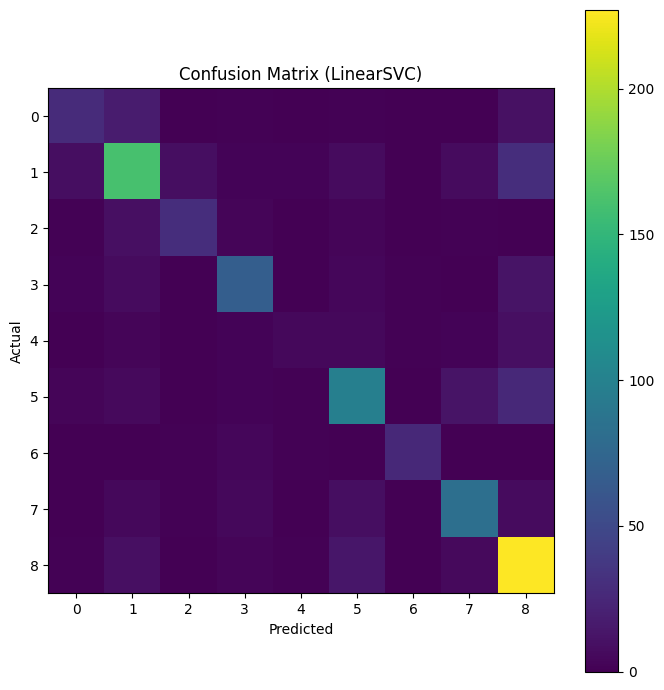

,index,label_name
0,0,IT_과학
1,1,경제
2,2,국제
3,3,문화
4,4,미분류
5,5,사회
6,6,스포츠
7,7,정치
8,8,지역


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 혼동행렬 계산
# cm[i, j]는 실제 라벨 i를 라벨 j로 예측한 개수.
# 완벽하면 대각선(왼쪽 위 → 오른쪽 아래)이 진하게 나오고, 대각선 바깥(오분류)은 어두워야 한다.
cm = confusion_matrix(y_test, svc_pred)

# 7x7 인치 크기의 캔버스 생성.
# imshow(cm)로 2D 행렬을 이미지처럼 표시(값이 클수록 색이 짙어짐).
# colorbar()는 오른쪽에 색상–값 범례.
fig = plt.figure(figsize=(7, 7))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (LinearSVC)")
plt.colorbar()

# 축 눈금(틱) 설정
# x축: Predicted(예측)
# y축: Actual(실제)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# 축 라벨/레이아웃/표시
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# (선택) 인덱스→라벨명 매핑 테이블
label_map = pd.DataFrame({"index": np.arange(len(classes)), "label_name": classes})
label_map

## 9. 오분류 분석: 상위 혼동쌍과 예시 문서

In [ ]:
from collections import Counter

pairs = Counter(zip(y_test, svc_pred))
confused_pairs = pd.DataFrame(
    [(a, b, c) for (a, b), c in pairs.items() if a != b],
    columns=["actual", "pred", "count"]
).sort_values("count", ascending=False)

confused_pairs.head(10)

,actual,pred,count
1,1,8,30
8,5,8,26
16,0,1,17
2,8,5,14
7,3,8,12
10,5,7,12
21,0,8,10
17,8,1,9
19,2,1,9
3,4,8,9


## 해석

1. **(1 → 8, 30건)**

   * 실제 라벨 1인데 예측이 8로 가장 많이 틀림
   * 두 클래스가 문맥적으로 비슷하거나, stopwords 제거/벡터화 과정에서 차이가 약해진 가능성

2. **(5 → 8, 26건)**

   * 실제 5를 8로 오분류한 경우도 많음
   * 8번 라벨이 여러 클래스의 “흡수통”처럼 작동할 수 있음 → 대표 단어가 포괄적일 가능성

3. **(0 → 1, 17건)**

   * 0번과 1번도 꽤 혼동
   * 주제어가 겹치거나, 기사 톤이 비슷할 수 있음

4. **(8 → 5, 14건)**

   * 위 2번과 대칭 관계 (8 ↔ 5)
   * 즉, 5와 8은 서로도 많이 틀리고 있음 → 텍스트 패턴이 거의 비슷하단 증거

5. **(3 → 8, 12건)** / **(5 → 7, 12건)**

   * 특정 클래스들이 8, 7 쪽으로 끌려감

6. 나머지 (10건 이하)도 주로 특정 소수 라벨이 대형 라벨로 흡수되는 형태

## 9-1. 오분류 표 (라벨 인덱스 → 라벨명 매핑)

In [ ]:
# actual, pred를 라벨명으로 변환
confused_pairs_named = confused_pairs.copy()
confused_pairs_named["actual_name"] = confused_pairs_named["actual"].apply(lambda x: classes[x])
confused_pairs_named["pred_name"] = confused_pairs_named["pred"].apply(lambda x: classes[x])

# 보기 좋게 컬럼 순서 변경
confused_pairs_named = confused_pairs_named[
    ["actual", "actual_name", "pred", "pred_name", "count"]
]

confused_pairs_named.head(10)

,actual,actual_name,pred,pred_name,count
1,1,경제,8,지역,30
8,5,사회,8,지역,26
16,0,IT_과학,1,경제,17
2,8,지역,5,사회,14
7,3,문화,8,지역,12
10,5,사회,7,정치,12
21,0,IT_과학,8,지역,10
17,8,지역,1,경제,9
19,2,국제,1,경제,9
3,4,미분류,8,지역,9


### 주요 패턴 분석

1. **경제 ↔ 지역** (1 → 8, 30건)

   * 실제 경제 기사를 지역으로 잘못 분류
   * 경제 기사 중에서 특정 지역(예: 지방 경제, 부동산 등)을 다룬 경우, '지역' 키워드가 강하게 잡힌 듯

2. **사회 → 지역** (5 → 8, 26건)

   * 사회 문제 중 지역 이슈(지방 범죄, 사건사고 등)가 지역 카테고리로 흡수

3. **IT\_과학 → 경제** (0 → 1, 17건)

   * IT\_과학 기사 중 경제적 관점(주가, 기업 재무 등)을 포함한 경우 혼동

4. **지역 → 사회** (8 → 5, 14건)

   * 지역 카테고리가 사회 이슈와 섞임 (지역 사회문제 기사)

5. **문화 → 지역** (3 → 8, 12건)

   * 문화 행사나 축제가 특정 도시/지역 중심이면 ‘지역’ 라벨로 잘못 분류

6. **사회 → 정치** (5 → 7, 12건)

   * 사회적 사건 중 정치인, 정부가 관련된 경우 정치로 예측

7. **IT\_과학 → 지역** (0 → 8, 10건)

   * IT 행사/산업 뉴스가 특정 지역에서 개최된 경우

8. **지역 ↔ 경제 / 국제**

   * 지역과 경제, 국제 기사 간의 혼동이 다수

### 원인 추정

* '지역' 라벨(8)이 여러 주제에서 공통 키워드를 포함 → “지역”이 **포괄적 흡수 라벨**이 됨
* 카테고리 간 **경계가 모호** (예: 경제+지역, 사회+정치, IT+경제)
* 벡터화 시 **주제 구분 핵심 단어**가 Stopwords에 포함되었거나, n-gram 범위가 부족해 문맥을 못 잡음

### 개선 제안

1. **데이터 전처리 강화**

   * “지역” 기사에서 경제/사회/문화와 겹치는 단어를 확인 후 불용어 또는 특화 키워드 처리
   * 지역명, 도시명, 국가명 등을 별도 토큰으로 가중치 부여 가능

2. **n-gram 확장**

   * `(1, 3)` 또는 `(2, 3)`로 늘려서 문맥 구절을 더 잘 잡기

3. **클래스 불균형 보정**

   * `class_weight="balanced"` 옵션 적용 (특히 SVC, LogisticRegression에서)

4. **라벨 통합 검토**

   * ‘지역’이 너무 포괄적이라면 세분화 or 다른 라벨과 재조정


In [ ]:
# 최상위 혼동쌍 문서 10개 확인
if not confused_pairs.empty:
    a_top, b_top = confused_pairs.iloc[0][["actual", "pred"]]
    mask = (y_test==a_top) & (svc_pred==b_top)
    mis_df = pd.DataFrame({
        "text": X_test[mask],
        "actual_idx": a_top,
        "pred_idx": b_top,
        "actual": classes[a_top],
        "pred": classes[b_top]
    })
    print(mis_df.head(10))
else:
    print("오분류가 거의 없습니다.")

                                                text  actual_idx  pred_idx  \
0  정회인 기자 사모펀드 운용사 한앤컴퍼니 가 전국적인 집중호우로 피해를 겪은 주민들을...           1         8   
1  전북자치도와 전북도경제통상진흥원 이 2024년 핵심 수출지원 정책으로 운영한 찾아가...           1         8   
2  우크라이나 전쟁에서 드론의 활약이 두드러지면서 그간 주목받지 못하던 지대공 미사일의...           1         8   
3  경기 양주시 옥정신도시 마지막 남은 중심상가 복합용지 개발 관련 입주민들이 복합 쇼...           1         8   
4  전남 해남군 북평면 서홍리 마늘밭에서 일하고 있는 농꾼들 곽경근 기자 자연재해가 이...           1         8   
5  두 공사 감사기구 간 정보 및 기술 교류 우수사례 공유 인력 파견 통해 역량 강화 ...           1         8   
6  대구공공시설관리공단은 지난 24일 목산동에 위치한 북부사업소에서 지역 내 취약계층 ...           1         8   
7  HD현대중공업 이 한화오션 을 제치고 5000억 원 규모의 장보고 성능 개량 체계 ...           1         8   
8  온 오프라인 홍보 지원 선물세트도 하이트진로는 켈리와 블루리본 서베이가 함께하는 더...           1         8   
9  국민 1인당 기본 15만원을 지급하는 민생회복 소비쿠폰 1차 신청 사흘 만에 전체 ...           1         8   

  actual pred  
0     경제   지역  
1     경제   지역  
2     경제   지역  
3     경제   지역  
4     경제   지역  
5     경제   지역  
6     경제   지역  
7     경제   지역

**실제 오분류 결과 해석**

결과를 보면, 모델이 오분류한 문서들은 대부분 기업 활동, 경제 정책, 투자, 수출 지원 등 경제적 내용이 포함된 기사입니다.

하지만 이 기사들에는 '전북자치도', '경기 양주시', '전남 해남군', '대구공공시설관리공단'과 같이 특정 지역명이나 지역 관련 기관명이 자주 언급되고 있습니다.

**오분류가 발생한 원인 추론**

모델은 텍스트의 내용을 분류할 때 특정 단어의 빈도나 패턴을 학습합니다. 이 경우, 모델은 텍스트에 포함된 지역명(예: 전북, 경기, 대구)을 보고 이 기사를 '지역' 뉴스로 판단했을 가능성이 높습니다.

## 10. 실험 노브: TF-IDF/모델 빠른 비교 템플릿

In [ ]:
def quick_compare(tfidf_params_list, models):
    results = []
    for tfidf_params in tfidf_params_list:
        for name, clf in models:
            pipe = Pipeline([
                ("tfidf", TfidfVectorizer(**tfidf_params)),
                ("clf", clf),
            ])
            pipe.fit(X_train, y_train)
            pred = pipe.predict(X_test)
            acc = accuracy_score(y_test, pred)
            results.append({
                "tfidf": tfidf_params,
                "model": name,
                "accuracy": acc
            })
            print(f"{name} | {tfidf_params} | acc={acc:.4f}")
    return pd.DataFrame(results).sort_values("accuracy", ascending=False)

param_grid = [
    dict(min_df=3, max_df=0.9, ngram_range=(1,2), sublinear_tf=True, stop_words=stopwords_kr),
    dict(min_df=5, max_df=0.85, ngram_range=(1,3), sublinear_tf=True, stop_words=stopwords_kr),
    dict(analyzer="char_wb", ngram_range=(2,5), min_df=3, max_df=1.0, sublinear_tf=True, stop_words=None),
]

model_list = [
    ("LinearSVC", LinearSVC(random_state=RANDOM_STATE)),
    ("LogReg", LogisticRegression(max_iter=3000, solver="saga", n_jobs=-1, random_state=RANDOM_STATE)),
    ("ComplementNB", ComplementNB())
]

# 실행
quick_results = quick_compare(param_grid, model_list)
quick_results.head()

LinearSVC | {'min_df': 3, 'max_df': 0.9, 'ngram_range': (1, 2), 'sublinear_tf': True, 'stop_words': ['기자', '사진', '제공', '밝혔다', '있다', '위해', '것', '등', '으로', '하고', '하는', '했다', '된다', '하며', '한', '가', '은', '는', '을', '를']} | acc=0.7260
LogReg | {'min_df': 3, 'max_df': 0.9, 'ngram_range': (1, 2), 'sublinear_tf': True, 'stop_words': ['기자', '사진', '제공', '밝혔다', '있다', '위해', '것', '등', '으로', '하고', '하는', '했다', '된다', '하며', '한', '가', '은', '는', '을', '를']} | acc=0.6630
ComplementNB | {'min_df': 3, 'max_df': 0.9, 'ngram_range': (1, 2), 'sublinear_tf': True, 'stop_words': ['기자', '사진', '제공', '밝혔다', '있다', '위해', '것', '등', '으로', '하고', '하는', '했다', '된다', '하며', '한', '가', '은', '는', '을', '를']} | acc=0.7180
LinearSVC | {'min_df': 5, 'max_df': 0.85, 'ngram_range': (1, 3), 'sublinear_tf': True, 'stop_words': ['기자', '사진', '제공', '밝혔다', '있다', '위해', '것', '등', '으로', '하고', '하는', '했다', '된다', '하며', '한', '가', '은', '는', '을', '를']} | acc=0.6970
LogReg | {'min_df': 5, 'max_df': 0.85, 'ngram_range': (1, 3), 'sublinear_tf': True, 'st

,tfidf,model,accuracy
6,"{'analyzer': 'char_wb', 'ngram_range': (2, 5),...",LinearSVC,0.766
8,"{'analyzer': 'char_wb', 'ngram_range': (2, 5),...",ComplementNB,0.728
7,"{'analyzer': 'char_wb', 'ngram_range': (2, 5),...",LogReg,0.727
0,"{'min_df': 3, 'max_df': 0.9, 'ngram_range': (1...",LinearSVC,0.726
2,"{'min_df': 3, 'max_df': 0.9, 'ngram_range': (1...",ComplementNB,0.718


세 가지 텍스트 분류 모델(`LinearSVC`, `LogisticRegression`, `ComplementNB`)과 세 가지 TF-IDF 벡터화 방법의 성능 비교

### 주요 결과
- **최고 성능 모델**: `LinearSVC` 모델이 가장 높은 정확도(0.7660)를 기록했습니다.
- **최고 성능 TF-IDF 설정**: `analyzer`를 `char_wb`로 설정하고, `ngram_range`를 `(2, 5)`로 사용했을 때 가장 좋은 결과가 나왔습니다.

---

### 결과 분석

| 순위 | 모델명 | TF-IDF 파라미터 | 정확도(Accuracy) |
|:---|:---|:---|:---|
| **1** | **LinearSVC** | **{'analyzer': 'char_wb', 'ngram_range': (2, 5), 'min_df': 3, ...}** | **0.7660** |
| 2 | ComplementNB | {'analyzer': 'char_wb', 'ngram_range': (2, 5), 'min_df': 3, ...} | 0.7280 |
| 3 | LogReg | {'analyzer': 'char_wb', 'ngram_range': (2, 5), 'min_df': 3, ...} | 0.7270 |

- **`char_wb` vs. 일반 n-gram**: `analyzer='char_wb'` (단어 경계 문자 n-그램)를 사용한 세 실험이 모두 상위 3위를 기록했습니다. 이는 한국어와 같이 띄어쓰기나 형태소 분석이 어려운 언어의 특성상, 문자 단위의 n-gram이 더 한국어의 특징을 잡아낼 수 있는 데 효과적임을 보여줍니다.
- **`stop_words`**: `char_wb`를 사용한 실험에서는 `stop_words` 파라미터를 사용하지 않았는데, 이는 문자 단위 분석 특성상 불용어를 따로 제거할 필요가 없기 때문입니다.
- **모델별 성능**: 모든 TF-IDF 조합에서 `LinearSVC`가 가장 높은 정확도를 보였고, `ComplementNB`와 `LogisticRegression`이 2, 3위를 했습니다. 이는 LinearSVC가 고차원 희소 벡터(sparse vector)인 TF-IDF 데이터에 가장 강력한 성능을 발휘합니다.

### 결론
이번 실험을 통해 **TF-IDF의 벡터화 방법론**이 단순히 모델을 변경하는 것보다 성능에 더 큰 영향을 미칠 수 있다는 점을 확인할 수 있습니다. 특히 한국어 텍스트 분류에서는 문자 단위 n-gram을 활용한 `char_wb` 방식이 효과적인 기본 모델(Baseline)이 될 수 있습니다.

### 정리
- 파이프라인으로 데이터 누수 방지, 코드 간소화
- 정확도 외 F1, 혼동행렬로 클래스별 편차 확인
- 선형 모델/char n-gram이 한국어 텍스트에서 강력한 베이스라인
- 빠른 파라미터/모델 비교 템플릿 제공